# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/) off the coast of New England. This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop. Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components. This is completely setup in Part 1, and includes:

* Expanding the control state vector
* Custom PTO physics
* Modeling non-hydrodynamic degrees of freedom

This tutorial is divided into three parts. The first sets up the problem including the points above. The second and third show results using a regular and irregular wave, respectively.

1. [Model setup](#1.-Model-setup)
2. [Regular wave results](#2.-Regular-wave-results)
3. [Irregular wave](#3.-Irregular-wave)


<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="307"></p>

In [78]:
import os
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with the setting up the different waves we want to model, as this will inform what to select for our frequency range, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site. The regular wave is roughly at 0.35 Hz, the known pitch resonance frequency of the buoy. The irregular wave has a peak period of 5 seconds, matching that of the deployment site.

In order to determine a suitable frequency range, it is best to complete an optimization with a large frequency range and examine the frequency domain results to see how large a range of frequencies is necessary to capture the relavent dynamics. Often, capturing nonlinear dynamics (such as due to constraints) requires a larger frequency range. In the case of the Pioneer WEC, it is clear that (likely due to the PTO torque constraint) the nonlinearities cause excitation at the odd harmonics of the excitation (which has a slightly larger frequency than the wave frequency itself). Specifically, the PTO force has peaks around the excitation frequency and at the 3rd harmonic (with a small peak at the 5th harmonic as well) which leads to peaks in the frequency spectrum of electrical power at the 2nd, 4th, and 6th harmonics. In order to fully capture these nonlinearities, we chose a frequency range from 0 to 1.875. 

Text(0.5, 0, 'frequency [Hz]')

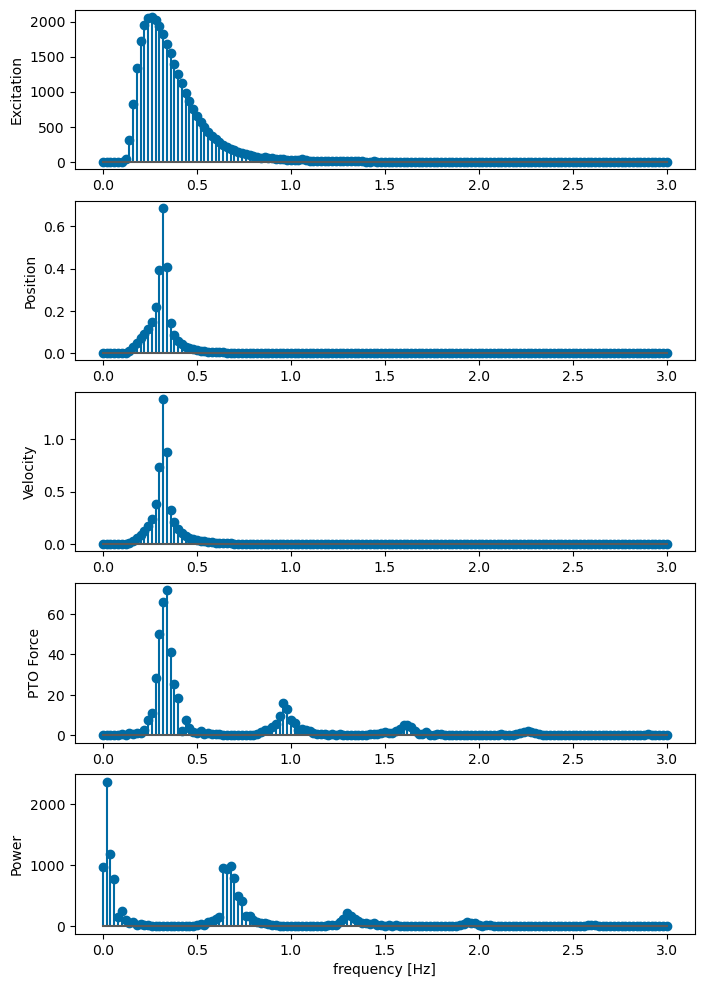

In [79]:
filename = 'data/tutorial_4_freq_range.nc'
results = wot.read_netcdf(filename)

fig, ax = plt.subplots(5,1,figsize=(8, 12))
ax[0].stem(results['freq'],abs(results['exc_force']))
ax[0].set_ylabel('Excitation')
ax[1].stem(results['freq'],abs(results['pos']))
ax[1].set_ylabel('Position')
ax[2].stem(results['freq'],abs(results['vel']))
ax[2].set_ylabel('Velocity')
ax[3].stem(results['freq'],abs(results['pto_force']))
ax[3].set_ylabel('PTO Force')
ax[4].stem(results['freq'],abs(results['power']))
ax[4].set_ylabel('Power')
ax[4].set_xlabel('frequency [Hz]')

After determining a frequency range of interest, it is important to make sure enough frequencies are included in the array to generate accurate results. The Pioneer WEC has a very narrow banded response, which means it requires a large number of frequencies to model the response accurately. For any WecOptTool analysis in irregular wave conditions, it is best to complete a convergence study on the number of frequencies in the wave conditions of interest. The convergence study shown below varies the number of frequencies and includes enough realizations to reach a 20 minute total simulation time (discussed further below). As shown below, an array of 150 frequencies is sufficient to model the system to within about 2% of the actual resultant mean power. Because the total computation time increases with increasing number of frequencies, it is desirable to select the number of frequencies to minimize the computation time while meeting the intended accuracy. 

Text(0, 0.5, 'Total computation time needed (20 min total simulation)')

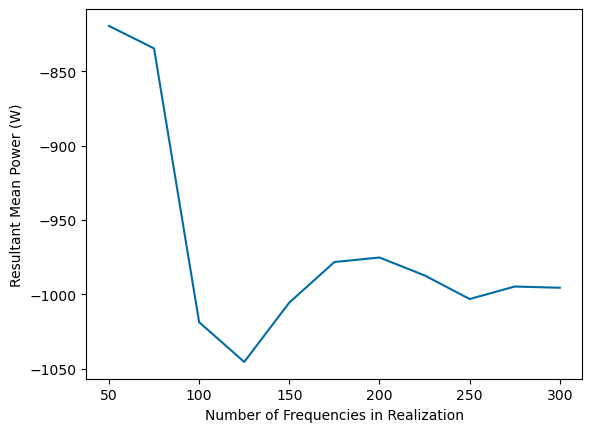

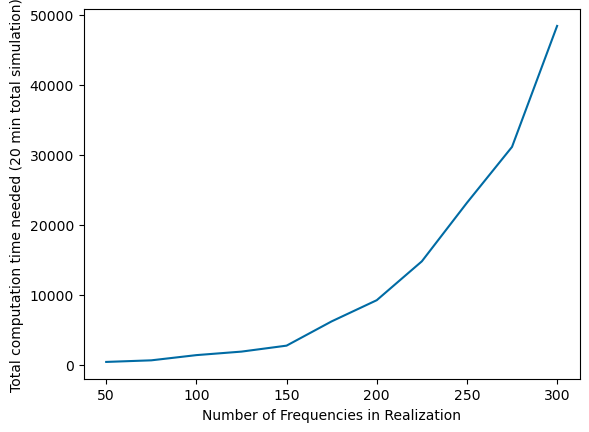

In [80]:
filename = 'data/tutorial_4_nfreqs.nc'
results = wot.read_netcdf(filename)

plt.figure()
plt.plot(results['nfreqs'],results['power'])
plt.xlabel('Number of Frequencies in Realization')
plt.ylabel('Resultant Mean Power (W)')
plt.figure()
plt.plot(results['nfreqs'],results['comp_time'])
plt.xlabel('Number of Frequencies in Realization')
plt.ylabel('Total computation time needed (20 min total simulation)')

Next, the number of realizations

In [81]:
# show nrealization convergence

In [82]:
nfreq = 300
f1 = 1.875/nfreq # Hz

#f1 = .35/10

In [83]:
# regular
amplitude = 0.15
wavefreq = 0.35
waves_regular = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)

# irregular
Hs = 1.5
Tp = 5 

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 2)

We plot the wave elevation spectra to check if the chosen frequency array covers the main excitation frequency, converges to zero for larger frequencies and can capture multiple harmonics which are required for nonlinear dynamics, since the states are multiplied with each other.
If the plot below does not cover the desired frequencies please adjust the frequency array.

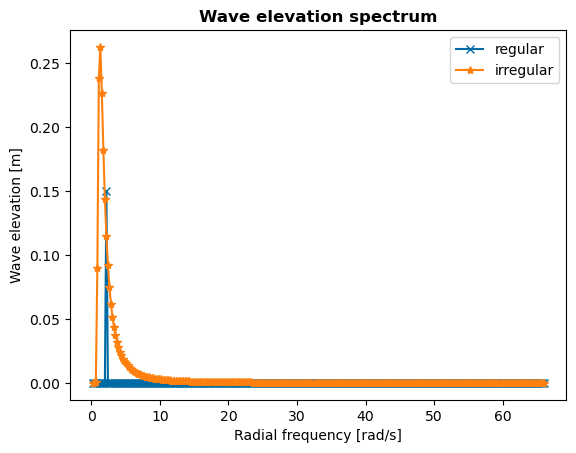

In [84]:
#TODO: highlight the harmonics if wave freq and Tp with other markers+colors
fig, ax = plt.subplots()
np.abs(waves_regular).plot(marker = 'x', label="regular")
np.abs(waves_irregular.sel(realization=0)).plot(marker = '*', label="irregular")
ax.set_title('Wave elevation spectrum', fontweight='bold')
plt.legend()

### 1.2 Basic properties
#### Geometry
To get the required hydrodynamic coefficients of the Pioneer design, we only need to be concerned with creating a mesh of the buoy geometry. The buoy has the same general shape as the WaveBot used in Tutorial 1, so we will use the build-in `geom.WaveBot` object and change the dimensions to simplify the mesh creation process.

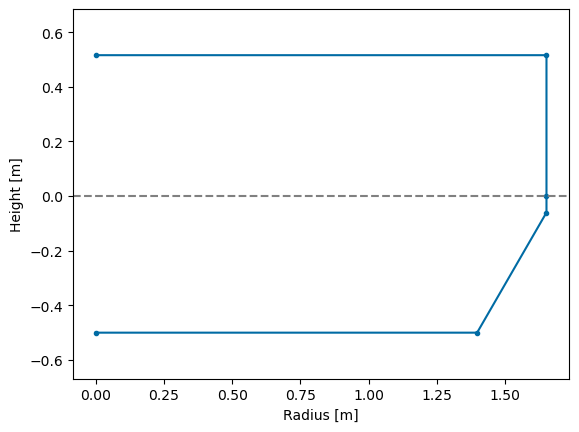

In [85]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.3)
_ = hull_geom.plot_cross_section()

#### Design properties
The Pioneer team has developed initial specifications for a full-sized WEC design that fits within the buoy dimensions and operating at resonance. There are several components that we need to capture in the PTO model:

* **Buoy**: As mentioned, this has the same basic geometric parameters as the WaveBot used in Tutorial 1. Since we're only modeling the pitch degree of freedom, we only need the pitch moment of inertia and not the mass of the buoy.
* **Flywheel**: The flywheel is contained and dimensioned to fit on top of the buoy. It rotates in pitch independently of the buoy, but is linked to the buoy through two parallel connections: the torsional spring and the generator. Since the flywheel is protected from wave loading by the buoy, it is **not** subject to hydrostatics or hydrodynamics.
* **Spring**: The magnetic torsional spring provides positive stiffness to the flywheel. It has a linear displacement up to 45 degrees, at which point it "wraps around" and the stiffness begins decreasing. For simplicity, we will model the spring as strictly linear. The spring is connected to a gearbox which makes the position of the spring (and therefore, the generator shaft) different from the relative position of the flywheel and buoy. 

A rendering of the Pioneer WEC model is shown here with the buoy pitch in red and the flywheel pitch in green:
<p><img src=https://live.staticflickr.com/65535/53025745404_2e75c89894_k.jpg alt="Diagram of the Pioneer device" width="500"></p>

In [86]:
buoy_props = {
    'CG': 0.242, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

flywheel_props = {
    'MOI': 25,  # kg-m^2
    'Coulomb friction': 2.0,  # N-m
    'Viscous friction': 0.02,  # N-m/rad
    'Gear ratio': 3, # -
}

spring_props = {
    'Max torque': 750, # N-m
    'Max displacement': np.deg2rad(45.0), # rad
}

#### Pitch resonator
This system uses a unique PTO system, where the generator velocity is dependent on the relative pitching rotation of the buoy and the flywheel. The system can be modeled as a coupled spring-mass-damper system, with the generator represented as $B_{PTO}$. The spring-mass-damper system and equivalent circuit model are shown below. Note that all of these values are rotational and are drawn here linearly for simplicity. 

<p><img src=https://live.staticflickr.com/65535/53025028262_1a4ba2d5ce_z.jpg alt="Pioneer model as a spring-mass-damper system" width="500"> <img src=https://live.staticflickr.com/65535/53025140497_29c5b9d601_z.jpg alt="Pioneer model as a spring-mass-damper system" width="180"></p>

This corresponds to the following dynamics equations:

(1) $$ [J_{buoy} + J(\omega))] \ddot{\theta}_{buoy} = T_{hydro} - K_{hydro}\theta_{buoy} - B(\omega)\dot{\theta}_{buoy} - K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 - (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

(2) $$ J_{flywheel} \ddot{\theta}_{flywheel} = K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 + (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

We will explore how to capture these dynamics in WecOptTool in the following sections.

#### Hydrodynamics and hydrostatics
As mentioned above, the `FloatingBody` object in Capytaine only needs to model the buoy, since no other components are being excited by the waves. The inertia matrix needs to be defined manually here since it is not based on the displaced mass.

[08:23:23] WARNING  The rotation dof Pitch has been initialized around the origin of the domain (0, 0, 0).

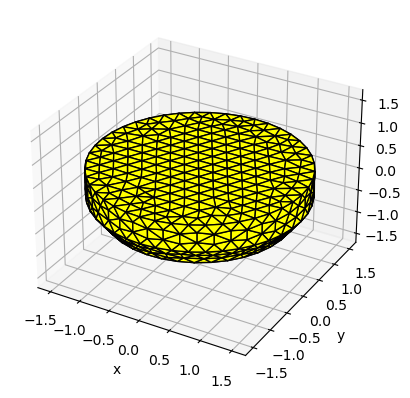

In [87]:
#from capytaine.io.meshio import load_from_meshio

#mesh_obj = capytaine.io.meshio.load_from_meshio(mesh, name="Pioneer")
lid_pos = cpt


pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs
pnr_fb.show_matplotlib()

pnr_fb.inertia_matrix = xr.DataArray([[buoy_props['MOI']]],
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof' : ['Pitch'],
                            'radiating_dof' : ['Pitch']},
                            name="inertia_matrix"
                            )

In [88]:
rho = 1025. # kg/m^3
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
omega = bem_data.omega.values

pnr_fb.keep_immersed_part()
k_spring = spring_props['Max torque'] / spring_props['Max displacement']
print(f"Hydrostatic stiffness from Capytaine: {bem_data['hydrostatic_stiffness'].values.squeeze()} N-m/rad")
print('Hydrostatic stiffness from experiment: 37204 N-m/rad')

           WARNING  center_of_mass already defined as [0.    0.    0.242].

           WARNING  rotation_center already defined as [0.    0.    0.242].

The resolution of the mesh might be insufficient for omega ranging from 6.597 to 65.973.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 542 problems:                                                              
                    The resolution of the mesh might be insufficient for omega ranging from 6.597 to 65.973.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Irregular frequencies might be encountered for omega ranging from 4.838 to 65.973.
Setting a lid for the floating body is recommended.


[08:23:27] WARNING  Irregular frequencies for 558 problems:                                                        
                    Irregular frequencies might be encountered for omega ranging from 4.838 to 65.973.             
                    Setting a lid for the floating body is recommended.

Output()

Hydrostatic stiffness from Capytaine: 40408.752778872986 N-m/rad
Hydrostatic stiffness from experiment: 37204 N-m/rad


As with previous tutorials, we will plot the hydrodynamic coefficients to confirm that we are properly capturing the full excitation range of the buoy.

Text(0.5, 1.0, 'Radiation Damping Coefficients')

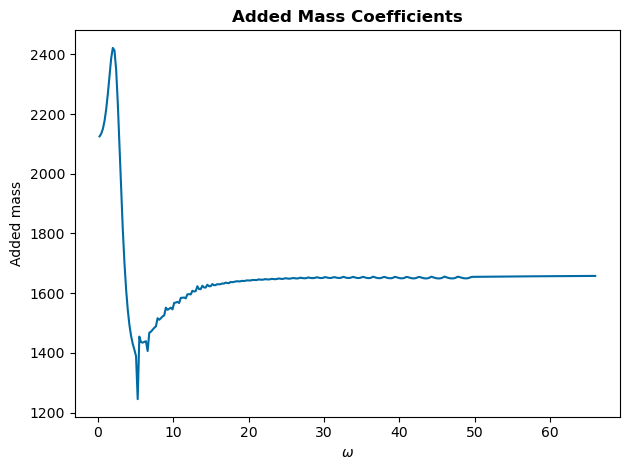

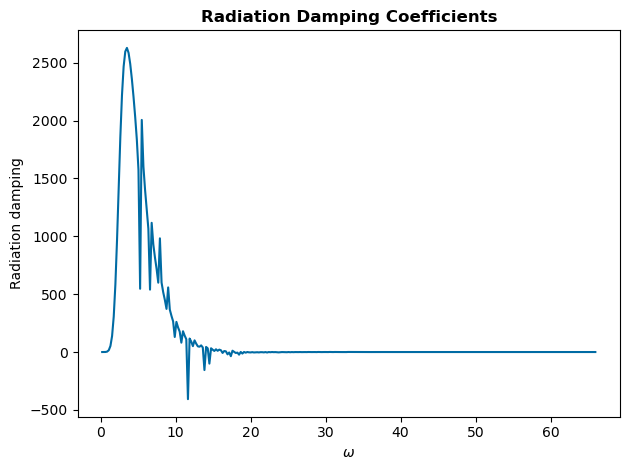

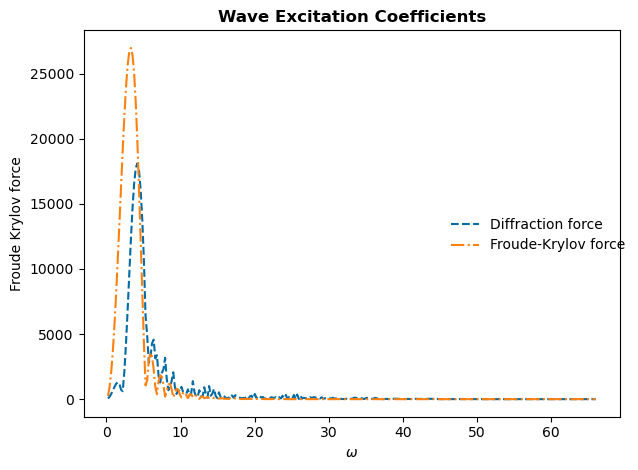

In [89]:
# Plots
fig_am, ax_am = plt.subplots(tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(tight_layout=True, sharex=True)

# Excitation
np.abs(bem_data.diffraction_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashed', label='Diffraction force')
np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof='Pitch')).plot(
    ax=ax_ex, linestyle='dashdot', label='Froude-Krylov force')
ex_handles, ex_labels = ax_ex.get_legend_handles_labels()
ax_ex.set_xlabel(f'$\omega$', fontsize=10)
ax_ex.set_title('Wave Excitation Coefficients', fontweight='bold')
fig_ex.legend(ex_handles, ex_labels, loc='center right', frameon=False)

# Added mass
bem_data.added_mass.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_am)
ax_am.set_xlabel(f'$\omega$', fontsize=10)
ax_am.set_title('Added Mass Coefficients', fontweight='bold')

# Radiation damping
bem_data.radiation_damping.sel(
    radiating_dof='Pitch', influenced_dof='Pitch').plot(ax=ax_rd)
ax_rd.set_xlabel(f'$\omega$', fontsize=10)
ax_rd.set_title('Radiation Damping Coefficients', fontweight='bold')

<xarray.DataArray 'inertia_matrix' (influenced_dof: 1, radiating_dof: 1)>
array([[7484.]])
Coordinates:
    g               float64 9.81
    rho             float64 1.025e+03
    body_name       <U16 'Pioneer_immersed'
    water_depth     float64 inf
    forward_speed   float64 0.0
  * radiating_dof   (radiating_dof) object 'Pitch'
  * influenced_dof  (influenced_dof) object 'Pitch'


(-100.0, 100.0)

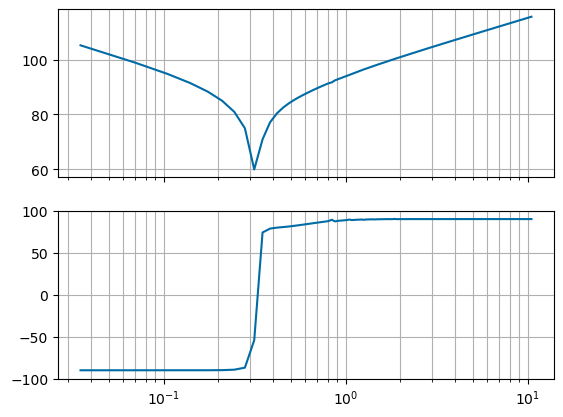

In [90]:
# plot impedance to see narrow-bandedness

# Plot Device Impedance
hydro_data = wot.add_linear_friction(bem_data)
Zi = wot.hydrodynamic_impedance(hydro_data)

print(hydro_data['inertia_matrix'])

fig, axs = plt.subplots(2, 1,sharex='all', sharey='row', squeeze=False)

p1 = np.squeeze(20*np.log10(np.abs(Zi)))
p2 = np.squeeze(np.rad2deg(np.angle(Zi)))

axs[0, 0].semilogx(freq, p1, '-', label='Intrinsic Impedance')
axs[1, 0].semilogx(freq, p2, '-', label='Intrinsic Impedance')
axs[0, 0].grid(True, which='both')
axs[1, 0].grid(True, which='both')
#axs[0, 0].set_ylim(60, 90)
axs[1, 0].set_ylim(-100, 100)
#axs[0, 0].set_xlim(.1, 0.9)

### 1.3 PTO
The generator shaft velocity is the difference between the buoy velocity and the flywheel velocity. Because the velocity PTO depends not only on the hydrodynamic states (`x_wec`, buoy pitch) but also on an additional non-hydrodynamic state (flywheel pitch), we cannot use the `PTO` module we have used in previous tutorials. Instead, we will make two adjustments to our model compared to previous tutorials:

1. We will adjust the `x_opt` vector to include the flywheel motion
2. We will manually define the equations for the PTO dynamics and energy equations

#### Capturing flywheel motions
In previous tutorials, all the relevant WEC dynamics have been captured in the `x_wec` vector. However, `x_wec` assumes all the degrees of freedom are excited by waves, which is not the case for the flywheel in the Pioneer model.

The `x_opt` vector has previously only been used to model the PTO force. However, there is no limit to what `x_opt` can include; it can theoretically include anything that is needed to model the PTO control. Since we need to capture the flywheel dynamics to properly model the PTO, we will append the Fourier coefficients of the flywheel's position to `x_opt`. The first part of `x_opt` will continue to be used for the PTO force (e.g. Fourier coefficients of the force time-series for an unstructured controller). 

Note in the code further down that `x_opt` will be spliced as either `x_opt[:nstate_pto]` to exclude the flywheel position states, or `x_opt[nstate_pto:]` to exclude the PTO force states. Remember, `x_opt` can be defined arbitrarily, and specific meanings to the states are given elsewhere in the model.

In [91]:
nstate_pto = 2 * nfreq # PTO forces
nstate_fw = 2 * nfreq  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

#### Manually defining PTO equations
Instead of calling the `PTO` module, we will manually define the dynamics and energy equations needed for WecOptTool to calculate electrical power, our quantity of interest for this optimization problem. These equations are also needed for the additional forces and constraints defined later on.

##### Relative motion
Here we define functions for the relative motion of the buoy and flywheel, derived from `x_wec` and `x_opt` respectively.

In [92]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_fw

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

##### Unstructured controller
This is nearly identical to the `wot.pto.controller_unstructured` function, except `x_opt` is spliced to only include the first part, since we are also including the flywheel positions in the second part of `x_opt`.

In [93]:
def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
    motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, motor)

##### PTO Impedance
The PTO impedance is defined using the same 2-port impedance model as in previous tutorials. The drivetrain inertia, friction, and stiffness are not included here since they are accounted for in the modeling of the additional non-hydrodynamic degree of freedom, as additional forces and constraints below.

In [94]:
torque_constant = 3.512
winding_resistance = 0.304

z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

When using the `PTO` module, the 2x2 impedance matrix is passed to the `wot.pto.PTO` object and converted into a transfer matrix to calculate the power at each frequency. While we're not using the `PTO` module, we will repeat this process almost verbatim here; see the `_make_abcd` and `_make_mimo_transfer_mat` functions in the `PTO` module if you are interested in more technical details.

In [95]:
z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

##### Power and Energy
Finally, we will wrap the relative motions, force, and impedance functions together to calculate average electrical power. This is again very close to what is found in the `PTO` module, except `rel_velocity` replaces `wot.pto.PTO.velocity` and `f_motor` replaces `wot.pto.PTO.force`.

In [96]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = f_motor(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints
The Pioneer model only contains one constraint based on the motor being used:
 * **Peak torque** - The motor should avoid torques greater than 120 N-m. This is the same basic constraint as `const_f_pto` from Tutorial 1, except we use our `f_motor` definition instead of `wot.pto.PTO.force_on_wec`.

### 1.5 Additional forces
Here we add in the forces acting on the bodies other than those generated from wave loading.
 * **Motor damping** - The resisting torque resulting from the damping on the PTO. This is very similar to the `wot.pto.PTO.force_on_wec` additional force given in previous tutorials.  This is already being accounted for by the `f_motor` function above.
 * **Flywheel friction** - The dissipative torque from the generator and components. This is defined as a nonlinear force using both Coulomb friction (dependent on the PTO direction) and the viscous friction (dependent on the PTO speed).
 * **Magnetic spring** - The restoring torque caused by the torsional spring between the buoy and flywheel. Note the gear ratio is included in this equation, as the gearbox is connected in series with the spring. The position of the spring is the relative position of the flywheel and buoy scaled by the reciprocal of gear ratio squared. 

### 1.6 Flywheel residual equation
To make sure the flywheel dynamics are properly modeled in the pseudo-spectral method, we will introduce an equality constraint consisting of Newton's 2nd law of motion on the flywheel in residual form (i.e. $r(x) = I \alpha - \tau = 0 $). This is the same structure as the residual for the WEC dynamics described in the [WecOptTool theory documentation](https://sandialabs.github.io/WecOptTool/theory.html); also compare this equation to the 2nd dynamics equation listed [above](#pitch-resonator).

This is required because the equations of motion described by `x_wec` only capture the buoy pitch degree of freedom. This provides a second equality constraint which will result in the correct two coupled dynamic equations.

We now create the additional forces and constaints that will be passed to the `WEC` object. Note that `f_add` only pertains to the buoy since that is the only degree of freedom included in the BEM data; our flywheel residual equation handles these forces for the flywheel in the opposite direction.

In [97]:
torque_peak_max = 80.
def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
    torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return -1 * (
        np.tanh(rel_vel) * flywheel_props['Coulomb friction']
      + rel_vel * flywheel_props['Viscous friction']
    )

def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
    spring_force = -k_spring  * pos
    return spring_force

def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_props['MOI'] * acc_fw

def const_flywheel_resid(wec, x_wec, x_opt, waves):
    return (fw_inertia(wec, x_wec, x_opt, waves)
          + f_spring(wec, x_wec, x_opt, waves)
          #+ f_friction(wec, x_wec, x_opt, waves)
          + f_motor(wec, x_wec, x_opt, waves)
          ).flatten()

f_add = {
    'Motor': f_motor,
    #'Friction': f_friction,
    'Spring': f_spring,   
}

constraints = [
#    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

### 1.7 WEC object
We now have all the information required to create our `WEC` object.

In [98]:
wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

  95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136
 137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164
 166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220
 221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249
 250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272
 273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292
 293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)


[08:24:10] WARNING  Linear damping for DOF "Pitch" has negative or close to zero terms. Shifting up damping terms [
                    52  62  65  73  76  77  78  81  82  83  85  87  89  90  91  92  93  94                         
                      95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113                       
                     114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136                       
                     137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164                       
                     166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195                       
                     196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220                       
                     221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249                       
                     250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272                       
                     273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292                       
                     293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)

## 2. Regular wave results
### 2.1 Solve
As always, we will optimize for electrical power absorption.

In [99]:
obj_fun = average_electrical_power
results = wec.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.8866662639507217
            Iterations: 11
            Function evaluations: 13
            Gradient evaluations: 11
Optimal average power: -288.67 W


In [100]:
constraints = [
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'eq', 'fun': const_flywheel_resid},
]

wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

obj_fun = average_electrical_power
results2 = wec.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

  95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136
 137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164
 166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220
 221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249
 250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272
 273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292
 293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)


[08:45:48] WARNING  Linear damping for DOF "Pitch" has negative or close to zero terms. Shifting up damping terms [
                    52  62  65  73  76  77  78  81  82  83  85  87  89  90  91  92  93  94                         
                      95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113                       
                     114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136                       
                     137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164                       
                     166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195                       
                     196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220                       
                     221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249                       
                     250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272                       
                     273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292                       
                     293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.417103533608558
            Iterations: 12
            Function evaluations: 14
            Gradient evaluations: 12
Optimal average power: -288.67 W


### 2.2 Post-process and plot
Again, since we're not using the `PTO` module, post-processing using `wot.pto.PTO.post_process` is not an option here, so we have to manually post-process the outputs related to the PTO and flywheel. This is pretty intuitive using the functions we created earlier. The outputs related to the buoy can still be derived directly from `wot.wec.post_process`.

In [101]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec,results, waves_regular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)


Some observations about the optimized Pioneer model:

 * The flywheel and buoy match frequency, but are out of phase due to the forcing from the spring and motor applied to both bodies.
 * The gearing in series with the torsional spring (which reduces the effective spring stiffness) significantly amplifies the rotation of the flywheel despite the buoy only pitching modestly. The gear ratio of 3 was selected by the Pioneer team to keep the system in resonance considering the spring stiffness, moment of inertia of the flywheel, and the resonance frequency of the buoy. Try increasing the gear ratio or flywheel moment of inertia -- this will actually reduce the power generated since it will bring the effective stiffness of the flywheel out of resonance, causing less motion relative to the buoy.
 * The mechanical and electrical power outputs are similar, since our impedance model has only a small amount of resistance and no inductance.
 * The buoy's pitch amplitude is larger than expected for this device and is likely due to underestimation of the radiation damping by the BEM. 

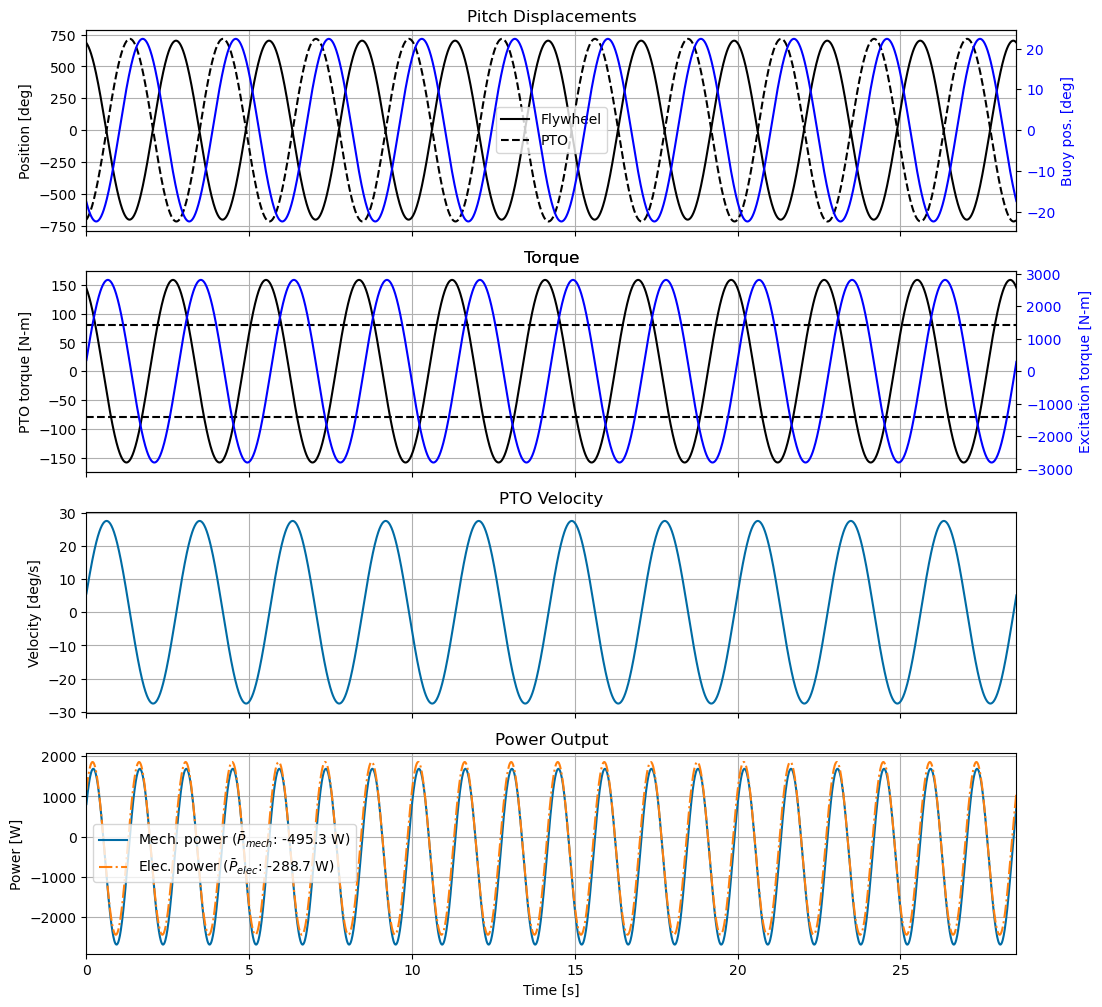

In [102]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom[0]['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

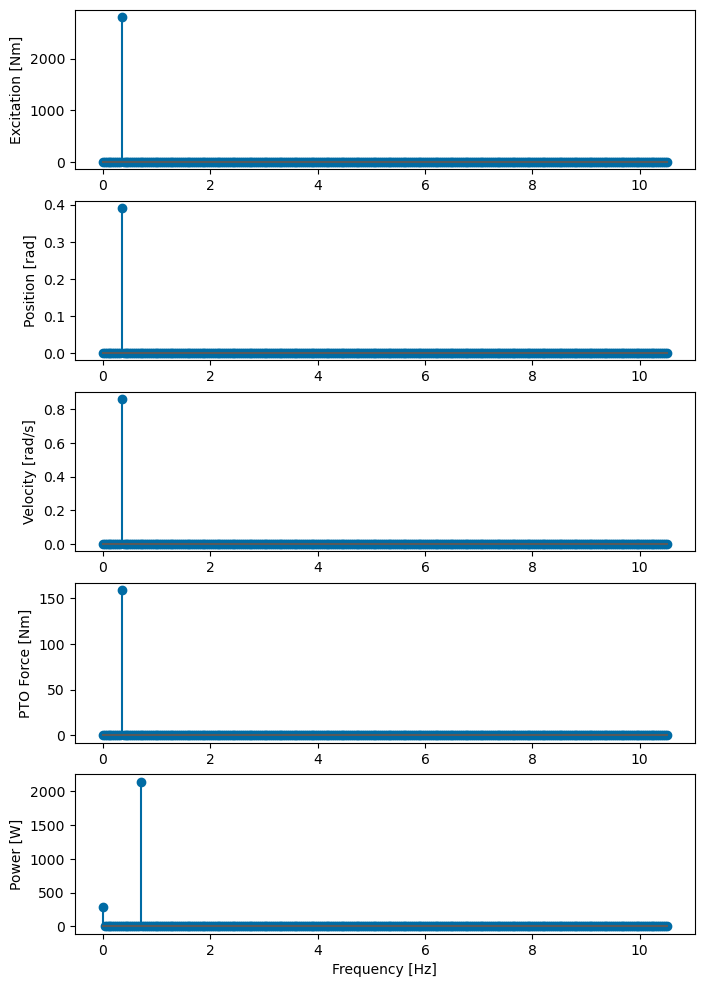

In [103]:
excitation_force = wec_fdom[0]['force'].sel(type='Froude_Krylov') + wec_fdom[0]['force'].sel(type='diffraction')
position = wec_fdom[0].pos
velocity = wec_fdom[0].vel
pto_force =  pto_force_fd
mech_power = wec.td_to_fd(pto_mech_power[::nsubsteps])
power = wec.td_to_fd(pto_elec_power[::nsubsteps])

wec_fdom, wec_tdom = wec.post_process(wec, results2, waves_regular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_new = f_motor(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force_new[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

excitation_force2 = wec_fdom[0]['force'].sel(type='Froude_Krylov') + wec_fdom[0]['force'].sel(type='diffraction')
position2 = wec_fdom[0].pos
velocity2 = wec_fdom[0].vel
pto_force2 =  pto_force_fd
mech_power2 = wec.td_to_fd(pto_mech_power[::nsubsteps])
power2 = wec.td_to_fd(pto_elec_power[::nsubsteps])

fig, ax = plt.subplots(5,1,figsize=(8, 12))

ax[0].stem(wec_fdom[0]['freq'],abs(excitation_force),label='Unconstrained (linear)')
#ax[0].stem(wec_fdom['freq'],abs(excitation_force2),'--',label='Constrained (nonlinear)',linefmt='orange')
ax[0].set_ylabel('Excitation [Nm]')

ax[1].stem(wec_fdom[0]['freq'],abs(position))
#ax[1].stem(wec_fdom['freq'],abs(position2),'--',linefmt='orange')
ax[1].set_ylabel('Position [rad]')

ax[2].stem(wec_fdom[0]['freq'],abs(velocity))
#ax[2].stem(wec_fdom['freq'],abs(velocity2),'--',linefmt='orange')
ax[2].set_ylabel('Velocity [rad/s]')

# Plot PTO force
ax[3].stem(wec_fdom[0]['freq'],abs(pto_force))
#ax[3].stem(wec_fdom['freq'],abs(pto_force2),'--',linefmt='orange')
ax[3].set_ylabel('PTO Force [Nm]')

# Plot power
#ax[5].stem(omegas,abs(mech_power))
ax[4].stem(wec_fdom[0]['freq'],abs(power))
#ax[4].stem(wec_fdom['freq'],abs(power2),linefmt='C1--')
ax[4].set_ylabel('Power [W]')
ax[4].set_xlabel('Frequency [Hz]')

#ax[0].legend()

fig.savefig('reg_lin.pdf', bbox_inches='tight')

### 2.3 Sankey Diagram

We use a Sankey diagram to visualize the average power flow from waves to electricity. On the very left is the theoretically possible optimal excitation. In order to reach this upper bound of exitation the WEC pitch velocity would need to be in phase with the pitch excitation force, in this case the radiated power is equal the amount of absorbed mechanical power. In practice, this will usually imply putting electrical power into the system (something we want to avoid!!!). 
With co-design, we are instead tapping the unused potential while limiting PTO losses and radiated power.

In [104]:
hydro_data = wot.add_linear_friction(bem_data, friction=None)    
hydro_data = wot.check_radiation_damping(hydro_data, uniform_shift=False)    


Zi = wot.hydrodynamic_impedance(hydro_data)
Rad_res = np.real(Zi.squeeze())

Fex = wec_fdom[0].force.sel(type=['Froude_Krylov', 'diffraction']).sum('type')
Vel = wec_fdom[0].vel

P_max_absorbable = (np.abs(Fex)**2/(8*Rad_res) ).squeeze().sum('omega').item() # after Falnes Eq. 6.10
P_opt_excitation = 2*P_max_absorbable # after Falnes Eq. 6.10
P_radiated = ((1/2)*(Rad_res * np.abs(Vel)**2 ).squeeze().sum('omega').item()) # after Falnes Eq. 6.4
P_excited= (1/4)*(Fex*np.conjugate(Vel) + np.conjugate(Fex)*Vel ).squeeze().sum('omega').item() # after Falnes Eq. 6.3
P_absorbed = P_excited - P_radiated # after Falnes Eq. 6.2 absorbed by WEC-PTO (difference between actual excitation power and actual radiated power needs to be absorbed by PTO)

  95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136
 137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164
 166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220
 221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249
 250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272
 273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292
 293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)


[10:02:34] WARNING  Linear damping for DOF "Pitch" has negative or close to zero terms. Shifting up damping terms [
                    52  62  65  73  76  77  78  81  82  83  85  87  89  90  91  92  93  94                         
                      95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113                       
                     114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136                       
                     137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164                       
                     166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195                       
                     196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220                       
                     221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249                       
                     250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272                       
                     273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292                       
                     293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)

We also calculate the power dissipated due to flywheel friction and make sure that the absorbed power (calculated as the difference between excited and radiated power) matches the sum of mechanical power captured by the PTO and the power dissipated due to flywheel friction. We use a relative tolerance of 1%.

In [105]:
def fw_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    vel_fw = np.dot(wec.derivative_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_fw)

def fw_friction_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = f_friction(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = fw_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

fw_fric_power = fw_friction_power(wec, x_wec, x_opt, waves_regular, nsubsteps)
avg_fw_fric_power = np.mean(fw_fric_power)

#assert(np.isclose(P_absorbed, -1*(avg_mech_power -avg_fw_fric_power), rtol=0.01)) # assert that solver solution matches

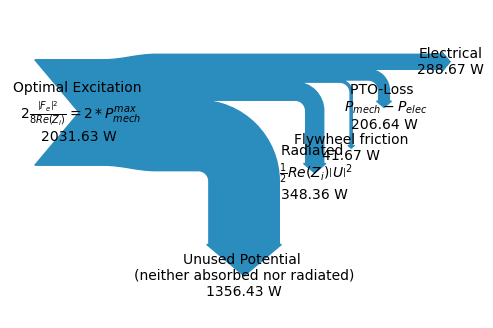

In [106]:
from matplotlib.sankey import Sankey

P_PTO_loss = avg_mech_power - avg_elec_power  
P_unused = P_opt_excitation - P_excited # Difference between the theoretical optimum excitation, if the WEC velocity would be in resonance with the excitation force

Power_flows = [P_opt_excitation, P_PTO_loss, -1*avg_fw_fric_power, -1*P_radiated, -1*P_unused, avg_elec_power, ]

fig = plt.figure(figsize = [6,4])
ax = fig.add_subplot(1, 1, 1,)
sankey = Sankey(ax=ax, 
                scale=0.5/P_max_absorbable,
                offset= 0,
                format = '%.2f W',shoulder = 0.02)

sankey.add(flows=Power_flows, 
           labels = ['Optimal Excitation \n $ 2 \\frac{\left | F_e \\right |^2}{8Re(Z_i)} = 2*P_{mech}^{max}$ ', 
                      'PTO-Loss \n $ P_{mech} - P_{elec}$', 
                      'Flywheel friction',
                      'Radiated \n $ \\frac{1}{2} Re(Z_i) \left | U \\right |^2  $ ', 
                      'Unused Potential \n(neither absorbed nor radiated)', 
                      'Electrical'], 
           orientations=[0, -1, -1,-1, -1, 0], # arrow directions
           pathlengths = [0.4,0.2,0.6,0.6,0.7,0.5,],
           trunklength = 1.5,
           edgecolor = '#2b8cbe',
           facecolor = '#2b8cbe' )

diagrams = sankey.finish()
for diagram in diagrams:
    for text in diagram.texts:
        text.set_fontsize(10);
plt.axis("off") 
plt.show()

## 3. Irregular wave
### 3.1 Solve
We will now run the same analysis for irregular waves. 

An interesting result is that due to the narrow banded resonance of the flywheel, the controller attempts to make the excitation force monochromatic with the resonant frequency. To achieve this it uses significant reactive power (power by the PTO into the system). This is still worth it, resulting in a larger average electrical power output. 

In [107]:
z_11 = np.array([[np.zeros(omega.shape)]])
off_diag = np.sqrt(3.0/2.0) * torque_constant
z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])

z_12_inv = np.linalg.inv(z_12.T).T
mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
abcd_11 = -1 * mmult(z_12_inv, z_11)
abcd_12 = z_12_inv
abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
abcd_22 = mmult(z_22, z_12_inv)
row_1 = np.hstack([abcd_11, abcd_12])
row_2 = np.hstack([abcd_21, abcd_22])
abcd = np.vstack([row_1, row_2])

for idof in range(2):
    for jdof in range(2):
        Zp = abcd[idof, jdof, :]
        re = np.real(Zp)
        im = np.imag(Zp)
        blocks = [np.array([[ire, iim], [iim, ire]])
                           for (ire, iim) in zip(re[:-1], im[:-1])]
        blocks = [re[0]] + blocks + [re[-1]]
        if jdof==0:
            row = block_diag(*blocks)
        else:
            row = np.hstack([row, block_diag(*blocks)])
    if idof==0:
        transfer_mat = row
    else:
        transfer_mat = np.vstack([transfer_mat, row])

wec = wot.WEC.from_bem(bem_data,
                       f_add=f_add,
                       constraints=constraints,
                       uniform_shift=False,
                       dof_names=bem_data.influenced_dof.values,)

obj_fun = average_electrical_power
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
power_results = [result.fun for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

  95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136
 137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164
 166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220
 221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249
 250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272
 273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292
 293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)


[10:02:35] WARNING  Linear damping for DOF "Pitch" has negative or close to zero terms. Shifting up damping terms [
                    52  62  65  73  76  77  78  81  82  83  85  87  89  90  91  92  93  94                         
                      95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112 113                       
                     114 115 116 117 118 119 120 121 122 123 124 126 127 129 130 132 133 136                       
                     137 139 140 142 143 144 145 147 148 151 152 154 157 158 159 162 163 164                       
                     166 167 171 172 173 178 179 180 181 187 188 189 190 191 192 193 194 195                       
                     196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 212 219 220                       
                     221 222 226 227 228 229 232 233 236 237 238 241 242 243 245 246 248 249                       
                     250 252 253 254 256 257 259 260 261 263 264 266 267 268 269 270 271 272                       
                     273 274 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 292                       
                     293 294 295 296 297 298 299] to a minimum of 1e-06 N/(m/s)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -12.615327593272315
            Iterations: 13
            Function evaluations: 15
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12.422721067403115
            Iterations: 13
            Function evaluations: 15
            Gradient evaluations: 13
Optimal average power: -1251.90 W


The solver is run 5 times (1 for each wave phase realization). Each of these phase realizations leads to a slightly different result for optimal average power. Thus, for irregular wave conditions, it is recommended to average the optimal average power result over multiple phase realizations. The number of phase realizations required is further discussed at the bottom of this notebook.

### 3.2 Post-process and plot

In [108]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec, results, waves_irregular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq)
fw_pos = np.dot(wec.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force = f_motor(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force_fd = wec.td_to_fd(pto_force[::nsubsteps])
pto_mech_power = mechanical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

rad_force = np.squeeze(wec_tdom[0]['force'].sel(type=['radiation']))
rad_force_fd = np.squeeze(wec_fdom[0]['force'].sel(type=['radiation']))

rad_power = rad_force*wec_tdom[0]['vel']

Text(0.5, 0, 'Time [s]')

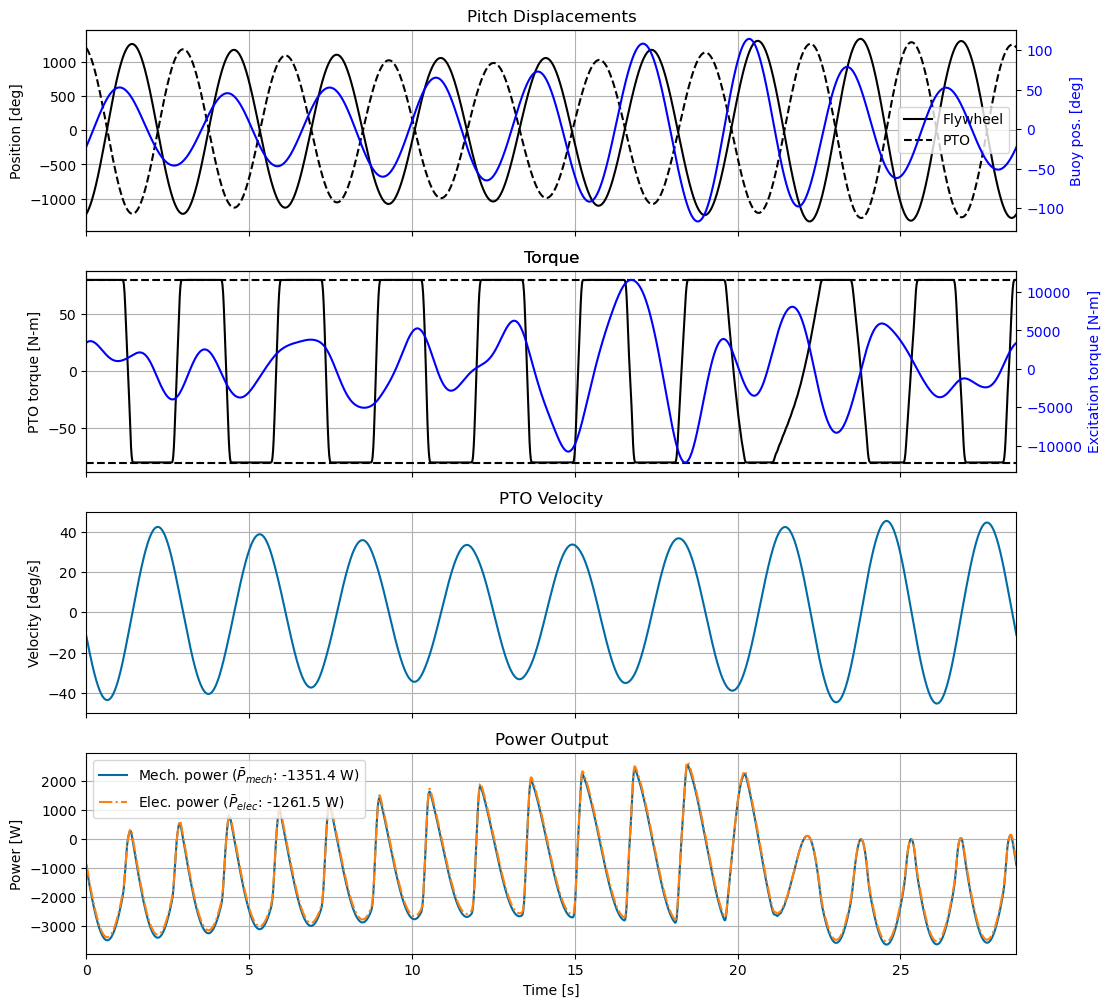

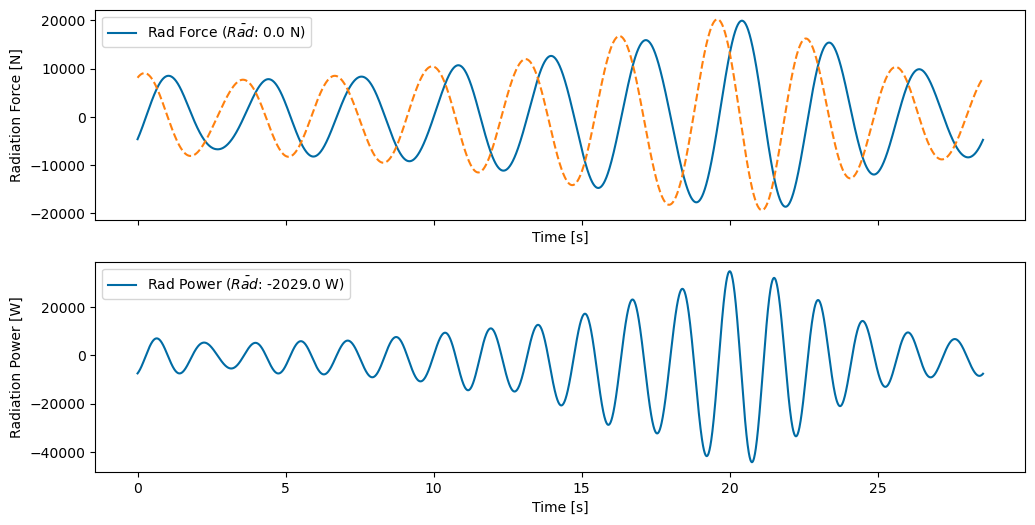

In [109]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [torque_peak_max, torque_peak_max], 'k--')
ax[1].plot([t[0], t[-1]], [-1*torque_peak_max, -1*torque_peak_max], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom[0]['force'].sel(type=['Froude_Krylov', 'diffraction']).sum('type').plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Power
ax[3].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[3].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[3].set_title('Power Output')
ax[3].set_ylabel('Power [W]')
ax[3].legend()
ax[3].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)
    
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))

# Power
ax[0].plot(t, rad_force, label='Rad Force ($\\bar{Rad}$: ' + f'{np.mean(rad_force):.1f} N)')
#ax[0].plot(t,np.squeeze(wec_tdom['force'].sel(type=['Friction']))*1e3,'-.',label='Friction')
ax[0].plot(t,np.squeeze(wec_tdom[0]['vel'])*5000,'--')
ax[0].set_ylabel('Radiation Force [N]')
ax[0].legend()
ax[0].set_xlabel('Time [s]')

ax[1].plot(t, rad_power, label='Rad Power ($\\bar{Rad}$: ' + f'{np.mean(rad_power):.1f} W)')
ax[1].set_ylabel('Radiation Power [W]')
ax[1].legend()
ax[1].set_xlabel('Time [s]')

Text(0.5, 0, 'frequency [Hz]')

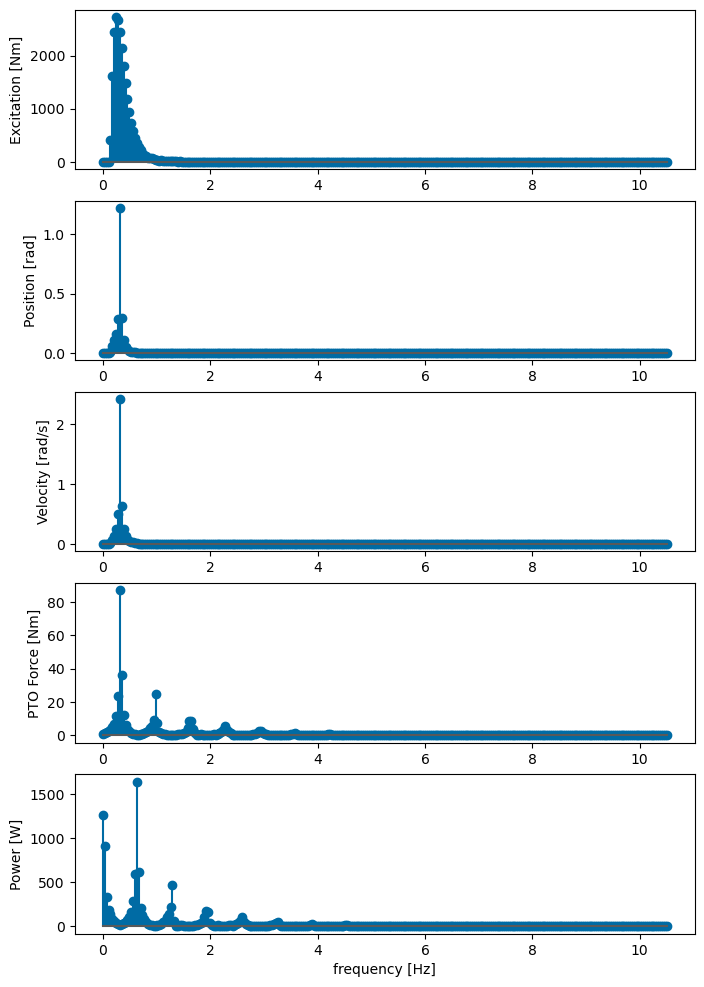

In [110]:
excitation_force = wec_fdom[0]['force'].sel(type='Froude_Krylov') + wec_fdom[0]['force'].sel(type='diffraction')
position = wec_fdom[0].pos
velocity = wec_fdom[0].vel
pto_force =  pto_force_fd
mech_power = wec.td_to_fd(pto_mech_power[::nsubsteps])
power = wec.td_to_fd(pto_elec_power[::nsubsteps])

fig, ax = plt.subplots(5,1,figsize=(8, 12))

ax[0].stem(wec_fdom[0]['freq'],abs(excitation_force))
ax[0].set_ylabel('Excitation [Nm]')

ax[1].stem(wec_fdom[0]['freq'],abs(position))
ax[1].set_ylabel('Position [rad]')

ax[2].stem(wec_fdom[0]['freq'],abs(velocity))
ax[2].set_ylabel('Velocity [rad/s]')

# Plot PTO force
ax[3].stem(wec_fdom[0]['freq'],abs(pto_force))
ax[3].set_ylabel('PTO Force [Nm]')

# Plot power
#ax[5].stem(omegas,abs(mech_power))
ax[4].stem(wec_fdom[0]['freq'],abs(power))
ax[4].set_ylabel('Power [W]')
ax[4].set_xlabel('frequency [Hz]')


In [ ]:
#print(results)

#print(power)

ds = xr.Dataset(data_vars=dict(
    exc_force=('freq', np.squeeze(excitation_force.values)),
    pos=('freq', np.squeeze(position.values)),
    vel=('freq', np.squeeze(velocity.values)),
    pto_force=('freq', np.squeeze(pto_force)),
    power=('freq', np.squeeze(power))),
    coords=dict(
    freq=wec_fdom['freq'].values)
)

print(ds)

wot.write_netcdf(os.path.join(os.getcwd(), 'data', 'tutorial_4_results_long.nc'), ds)

In [ ]:
# plot of 150 frequencies from 0 to 3
filename = 'data/tutorial_4_results_long.nc'
results_saved = wot.read_netcdf(filename)
print(results_saved)

Next, we want to demonstrate why it is recommended to test multiple phase realizations instead of testing a longer simulation time.

In [ ]:
meanpower = []

waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 100)

results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')
meanpower.append(power_results)

In [ ]:
import xarray as xr
res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('pioneer_power_convergence_150.nc')

In [ ]:
print(meanpower)

[[-991.4844412782528, -1029.9758275161516, -971.2816669447661, -957.1529057836668, -1035.0949688406863, -1008.0426766993958, -1027.9405121662035, -1043.3149008359044, -964.4016207876305, -1030.7953214080426, -1021.7685792271479, -1024.329361802293, -1029.8435380823305, -1029.1580258739566, -1032.8607949724733, -1027.0257227632997, -1010.7980289423642, -976.2608334739929, -1031.5611463059977, -1004.1504865676603, -979.488027883541, -980.5714462658336, -1022.2057972574131, -981.8358641243334, -958.1359892353832, -1017.3708761545507, -1017.1759898700642, -1045.2342988487346, -1015.2999195603633, -1032.5757281232377, -996.4231826940579, -1021.2949531380158, -1005.8395476920441, -1039.6670373102272, -1026.7428265408878, -1010.0131326792492, -1014.5205392831373, -976.5193756259765, -1017.1767422145061, -1001.7877632689091, -1021.4021381489964, -993.441052284827, -949.0174605427668, -1032.9780162635866, -998.7923654626735, -1033.8624478323613, -995.3278774160051, -1025.045502971757, -1005.871

Text(0, 0.5, 'Average Power (W)')

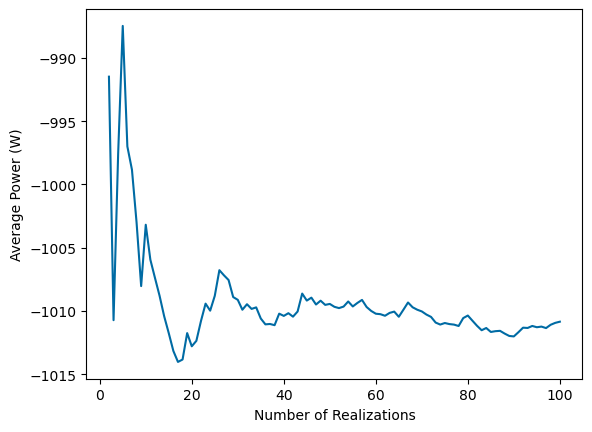

In [ ]:
power_list = [item for sublist in meanpower for item in sublist]

rolling_mean = []

for ind in range(len(power_list)):

    rolling_mean.append(np.mean(power_list[0:ind]))
    
plt.figure()
plt.plot(range(1,len(power_list)+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

22.253188328652417


Text(0.5, 0, 'Number of Realizations')

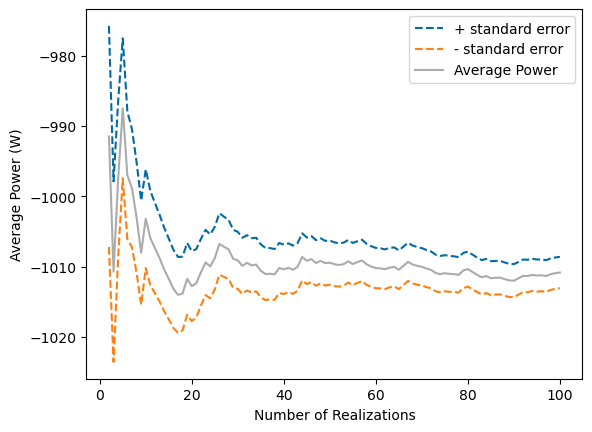

In [ ]:
# calculate standard deviation and divide by square root of sample size to get the standard error of the mean

rolling_sem = []
rolling_var = []

stdev = np.std(power_list)
print(stdev)

for ind in range(len(power_list)):
    
    rolling_var.append(stdev**2)
    
    rolling_sem.append(stdev/np.sqrt(ind+1))
    
rolling_sem_pos = [sum(x) for x in zip(rolling_sem, rolling_mean)]
rolling_sem_neg = [y-x for x, y in zip(rolling_sem, rolling_mean)]

rolling_var_pos = [sum(x) for x in zip(rolling_var, rolling_mean)]
rolling_var_neg = [y-x for x, y in zip(rolling_var, rolling_mean)]
    
plt.figure()
plt.plot(range(1,len(power_list)+1),rolling_sem_pos,'--',label='+ standard error')
plt.plot(range(1,len(power_list)+1),rolling_sem_neg,'--',label='- standard error')
#plt.plot(range(1,len(power_list)+1),rolling_var_pos)
#plt.plot(range(1,len(power_list)+1),rolling_var_neg)
plt.plot(range(1,len(power_list)+1),rolling_mean,label='Average Power')
plt.legend()
plt.ylabel('Average Power (W)')
plt.xlabel('Number of Realizations')

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.49e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel 

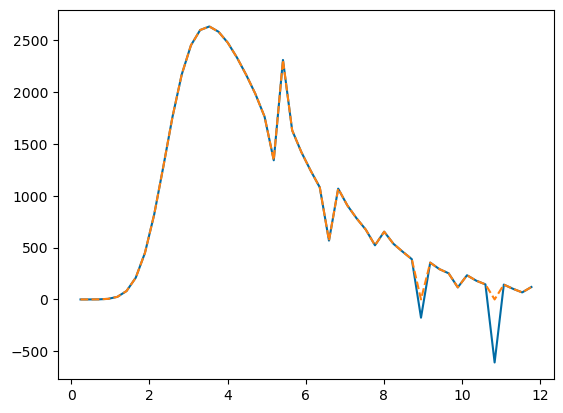

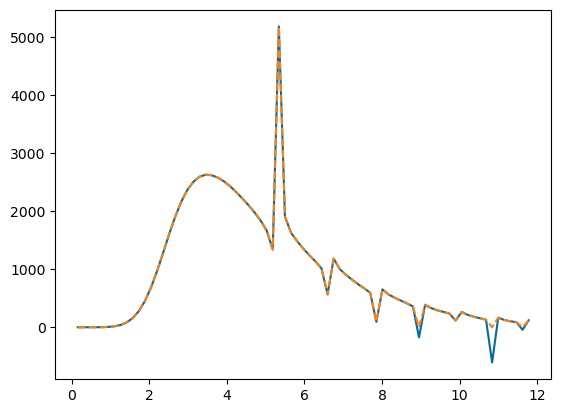

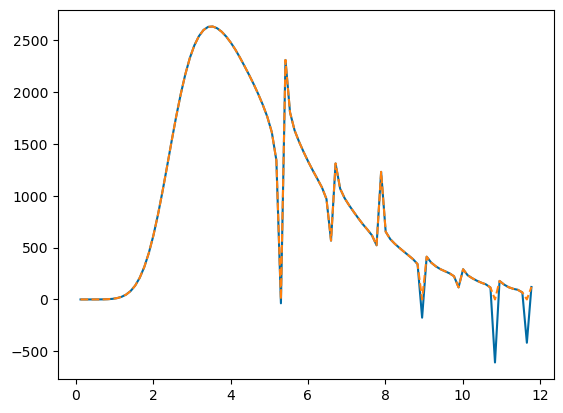

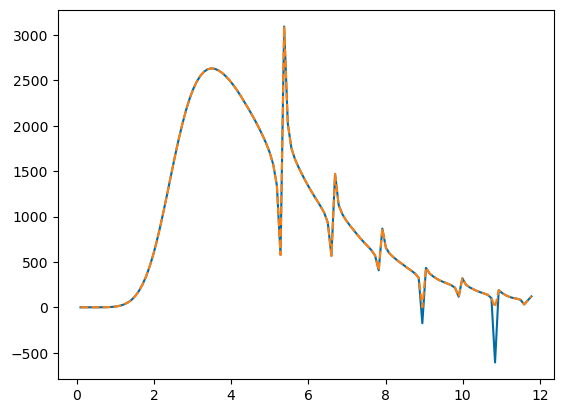

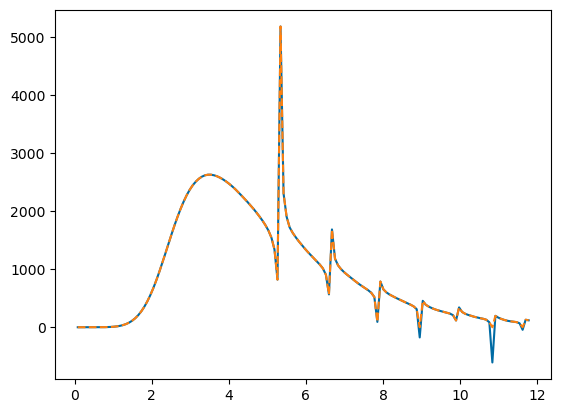

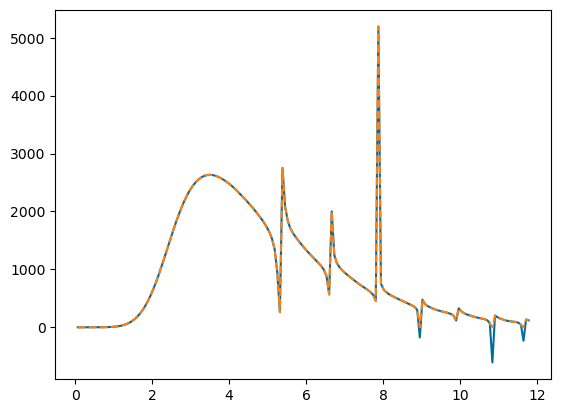

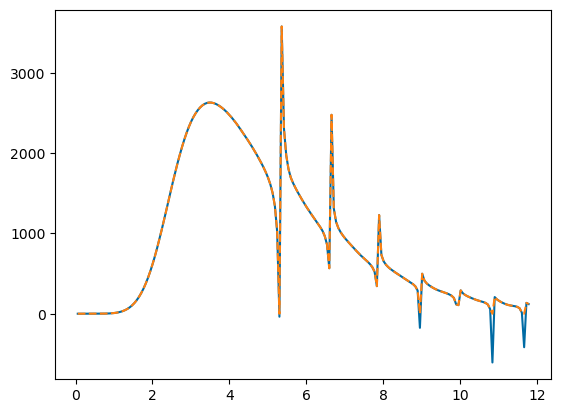

In [ ]:
nfreqs = [20, 40, 80, 160]
fend = 1.875

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
    
    plt.figure()
    plt.plot(bem_data['omega'],np.squeeze(bem_data['radiation_damping']))
    
    hydro_data = wot.add_linear_friction(bem_data,None)
    hydro_data = wot.check_linear_damping(hydro_data, 1e-6, False)
    plt.plot(bem_data['omega'],np.squeeze(hydro_data['radiation_damping']),'--')

    #efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    #waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)
    #fig, ax = plt.subplots()
    #plt1 = np.abs(waves_irregular.sel(realization=0)).plot(ax=ax, color='C0')

In [ ]:
import time

# compare run times vs. number of frequencies
nfreqs = np.linspace(50,300,11)
print(nfreqs)
fend = 1.875

runtime = []
meanpower = []
Pmaxs = []

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

minutes_needed = 20

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(pnr_fb, freq, rho=rho)
    omega = bem_data.omega.values
    
    nstate_pto = 2 * int(nfreq) # PTO forces
    nstate_fw = 2 * int(nfreq)  # Flywheel positions
    nstate_opt = nstate_pto + nstate_fw

    sim_time = (1/(fend/nfreq))
    nrealizations_needed = minutes_needed*60/sim_time
    nrealizations_needed = np.round(nrealizations_needed)
    nrealizations_needed = 2
    
    def x_rel(wec, x_wec, x_opt):
        pos_wec = wec.vec_to_dofmat(x_wec)
        pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
        return pos_wec - pos_fw

    def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_rel = x_rel(wec, x_wec, x_opt)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, pos_rel)

    def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_rel = x_rel(wec, x_wec, x_opt)
        vel_rel = np.dot(wec.derivative_mat, pos_rel)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, vel_rel)
    
    def f_motor(wec, x_wec, x_opt, waves, nsubsteps=1):
        motor = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        return np.dot(time_matrix, motor)
    
    torque_constant = 3.512
    winding_resistance = 0.304

    z_11 = np.array([[np.zeros(omega.shape)]])
    off_diag = np.sqrt(3.0/2.0) * torque_constant
    z_12 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
    z_21 = np.array([[-1*(off_diag+0j) * np.ones(omega.shape)]])
    z_22 = np.array([[winding_resistance * np.ones(omega.shape)]])
    
    z_12_inv = np.linalg.inv(z_12.T).T
    mmult = lambda a,b: np.einsum('mnr,mnr->mnr', a, b)
    abcd_11 = -1 * mmult(z_12_inv, z_11)
    abcd_12 = z_12_inv
    abcd_21 = z_21 - mmult(z_22, mmult(z_12_inv, z_11))
    abcd_22 = mmult(z_22, z_12_inv)
    row_1 = np.hstack([abcd_11, abcd_12])
    row_2 = np.hstack([abcd_21, abcd_22])
    abcd = np.vstack([row_1, row_2])

    for idof in range(2):
        for jdof in range(2):
            Zp = abcd[idof, jdof, :]
            re = np.real(Zp)
            im = np.imag(Zp)
            blocks = [np.array([[ire, iim], [iim, ire]])
                               for (ire, iim) in zip(re[:-1], im[:-1])]
            blocks = [re[0]] + blocks + [re[-1]]
            if jdof==0:
                row = block_diag(*blocks)
            else:
                row = np.hstack([row, block_diag(*blocks)])
        if idof==0:
            transfer_mat = row
        else:
            transfer_mat = np.vstack([transfer_mat, row])
    
    def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        force_td = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
        vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
        return vel_td * force_td

    def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        q1_td = rel_velocity(wec, x_wec, x_opt, waves)
        e1_td = f_motor(wec, x_wec, x_opt, waves)
        q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
        e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
        vars_1 = np.hstack([q1, e1])
        vars_1_flat = wec.dofmat_to_vec(vars_1)
        vars_2_flat = np.dot(transfer_mat, vars_1_flat)
        vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
        q2 = vars_2[:, 0]
        e2 = vars_2[:, 1]
        time_mat = wec.time_mat_nsubsteps(nsubsteps)
        q2_td = np.dot(time_mat, q2)
        e2_td = np.dot(time_mat, e2)
        return q2_td * e2_td

    def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
        power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
        return np.sum(power_td) * wec.dt/nsubsteps

    def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
        e = energy(wec, x_wec, x_opt, waves, nsubsteps)
        return e / wec.tf
    
    torque_peak_max = 120.
    def const_peak_torque_pto(wec, x_wec, x_opt, waves, nsubsteps=5):
        torque = f_motor(wec, x_wec, x_opt, waves, nsubsteps)
        return torque_peak_max - np.abs(torque.flatten())

    def f_friction(wec, x_wec, x_opt, waves, nsubsteps=1):
        rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
        return -1 * (
            np.tanh(rel_vel) * flywheel_props['Coulomb friction']
          + rel_vel * flywheel_props['Viscous friction']
        )

    def f_spring(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) / (flywheel_props['Gear ratio']**2)
        spring_force = -k_spring  * pos
        return spring_force

    def fw_inertia(wec, x_wec, x_opt, waves, nsubsteps=1):
        pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
        acc_fw = np.dot(wec.derivative2_mat, pos_fw)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        acc_fw = np.dot(time_matrix, acc_fw)
        return flywheel_props['MOI'] * acc_fw

    def const_flywheel_resid(wec, x_wec, x_opt, waves):
        return (fw_inertia(wec, x_wec, x_opt, waves)
              + f_spring(wec, x_wec, x_opt, waves)
              #+ f_friction(wec, x_wec, x_opt, waves)
              + f_motor(wec, x_wec, x_opt, waves)
              ).flatten()

    f_add = {
        'Motor': f_motor,
        #'Friction': f_friction,
        'Spring': f_spring,   
    }

    constraints = [
        #{'type': 'ineq', 'fun': const_peak_torque_pto},
        {'type': 'eq', 'fun': const_flywheel_resid},
    ]
    
    wec = wot.WEC.from_bem(bem_data,
                           f_add=f_add,
                           constraints=constraints,
                           uniform_shift=False,
                           dof_names=bem_data.influenced_dof.values,)

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    
    
    # usually, the spectrum function is used to calculate efth. 
    # Need to find a way to plug in the amplitude results from the above new method
    # Can we create a function that is applied by omnidirectional spectrum?
    def maintain_spectrum_integral(f):
        amplitudes = np.zeros(len(f),)
        for ind, f in enumerate(f):
            b_param = (1.057*fp)**4
            a_param = hs**2 / 4 * b_param
            spectrum_func = lambda f: a_param * f**(-5) * np.exp(-b_param * f**(-4))
            area = scipy.integrate.quad(spectrum_func,f-f1/2,f+f1/2)
            amplitudes[ind] = area[0]/f1
        return amplitudes

    #efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), maintain_spectrum_integral, "Pierson-Moskowitz")
    
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = int(nrealizations_needed))
    
    print(f'nfreq: {nfreq}')
    starttime = time.time()
    
    results = wec.solve(
        waves_irregular,
        obj_fun,
        nstate_opt=nstate_opt,
        scale_x_wec=1e1,
        scale_x_opt=1e-2,
        scale_obj=1e-2,
    )
    
    power_results = [result.fun for result in results]
    x_results = [result.x for result in results]
    print(f'Optimal average power: {np.mean(power_results):.2f} W')
    
    meanpower.append(np.mean(power_results))
    
    endtime = time.time()
    runtime.append(endtime-starttime)
    print(runtime)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

print(meanpower)
print(runtime)
print(Pmaxs)

import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=range(len(meanpower))))
res_ds.to_netcdf('pioneer_freq_linear.nc')

[ 50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300.]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


nfreq: 50.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.638121271459973
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.638121576845965
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimal average power: -963.81 W
[24.522381067276]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel 

nfreq: 75.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.421419231096074
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.421419118590487
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Optimal average power: -942.14 W
[24.522381067276, 57.94384479522705]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel 

nfreq: 100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.291552170483634
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.29155215838786
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15
Optimal average power: -1129.16 W
[24.522381067276, 57.94384479522705, 124.42516565322876]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


nfreq: 125.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.556421342843644
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.556421345706003
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimal average power: -1155.64 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel 

nfreq: 150.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.546047423205746
            Iterations: 16
            Function evaluations: 18
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.54604743840954
            Iterations: 16
            Function evaluations: 18
            Gradient evaluations: 16
Optimal average power: -1154.60 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.85e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel 

nfreq: 175.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.354822771724733
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.35482267686747
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15
Optimal average power: -1135.48 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.52e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel 

nfreq: 200.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.300234504361548
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.30023427252695
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimal average power: -1130.02 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673, 762.3405022621155]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.01e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel 

nfreq: 225.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.299461597581178
            Iterations: 17
            Function evaluations: 20
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.299461289179586
            Iterations: 17
            Function evaluations: 19
            Gradient evaluations: 17
Optimal average power: -1129.95 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673, 762.3405022621155, 1454.422694683075]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.39e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel 

nfreq: 250.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.31720237644517
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.317202354529961
            Iterations: 17
            Function evaluations: 19
            Gradient evaluations: 17
Optimal average power: -1131.72 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673, 762.3405022621155, 1454.422694683075, 2765.177580833435]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.19e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.48e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.78e-01.
This warning appears because the largest panel 

nfreq: 275.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.325195451373757
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.325195466343585
            Iterations: 17
            Function evaluations: 19
            Gradient evaluations: 17
Optimal average power: -1132.52 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673, 762.3405022621155, 1454.422694683075, 2765.177580833435, 4820.576815128326]


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


nfreq: 300.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.32595444062867
            Iterations: 17
            Function evaluations: 19
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11.325954353031072
            Iterations: 17
            Function evaluations: 19
            Gradient evaluations: 17
Optimal average power: -1132.60 W
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.1717462539673, 762.3405022621155, 1454.422694683075, 2765.177580833435, 4820.576815128326, 6078.467243432999]
[-963.8121424152969, -942.1419174843281, -1129.1552164435748, -1155.6421344274822, -1154.6047430807644, -1135.48227242961, -1130.0234388444248, -1129.9461443380383, -1131.7202365487565, -1132.519545885867, -1132.595439682987]
[24.522381067276, 57.94384479522705, 124.42516565322876, 204.567387342453, 443.5104079246521, 420.

<xarray.DataArray (freq: 200, dir: 1)>
array([[0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [1.09878818e-176],
       [4.57919526e-084],
       [1.58323582e-044],
       [1.82839717e-025],
       [2.02101344e-015],
       [9.16755337e-010],
       [2.06325108e-006],
       [2.39791373e-004],
       [4.89308701e-003],
       [3.44502800e-002],
       [1.23670974e-001],
       [2.86261744e-001],
       [4.94375691e-001],
       [6.99366025e-001],
       [8.61628329e-001],
       [9.63294452e-001],
...
       [7.98341278e-005],
       [7.76652598e-005],
       [7.55667091e-005],
       [7.35358305e-005],
       [7.15700921e-005],
       [6.96670693e-005],
       [6.78244406e-005],
       [6.60399819e-005],
       [6.43115620e-005],
       [6.26371389e-005],
       [6.10147549e-005],
       [5.94425330e-005],
       [5.79186733e-005],
       [5.64414492e-005],
       [5.50092043e-005],
       [5.36203489e-005],
       [5.22733574e-0